https://www.kaggle.com/robikscube/hourly-energy-consumption/version/3

https://towardsdatascience.com/playing-with-time-series-data-in-python-959e2485bff8

https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-prophet

https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

https://dashee87.github.io/deep%20learning/python/predicting-cryptocurrency-prices-with-deep-learning/

## Energy Consumption Prediction

### The dataset is obtained from Kaggle Dataset, and the original data is obtained from PJM Interconnection LLC.

### PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

### The hourly power consumption data comes from PJM's website and are in megawatts (MW).

### There are more than one power company's data in the original dataset. We will only explore the AEP (American Electrical Power) dataset in this project.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

import warnings
warnings.filterwarnings("ignore")

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
from fbprophet import Prophet

## Data Exploration

In [3]:
df=pd.read_csv('AEP_hourly.csv')

In [4]:
df.head(1)

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0


In [5]:
df.columns=['Time','MW']

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
Time    121273 non-null object
MW      121273 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


In [7]:
ts=pd.DataFrame(df['MW'])

## Indexing with Time Series Data

In [8]:
ts=ts.set_index(pd.to_datetime(df['Time']))
ts.head()

,MW
Time,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


## Visualizing Energy Consumption Time Series Data

<Figure size 1080x720 with 0 Axes>

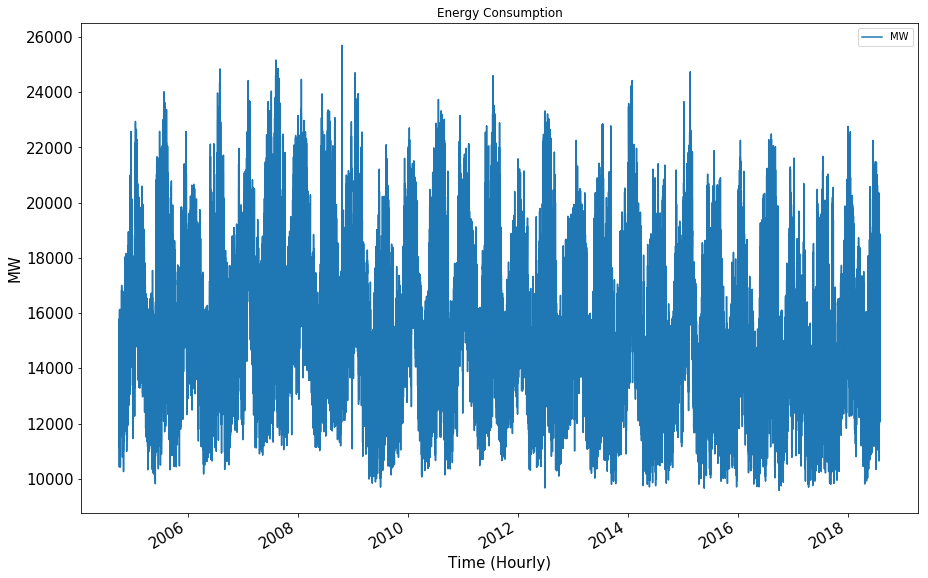

In [9]:
rcParams['figure.figsize'] = 15, 10
fig = plt.figure()
#plt.plot(ts)
ts.plot(fontsize=15)
plt.title('Energy Consumption')
plt.xlabel('Time (Hourly)', fontsize=15)
plt.ylabel('MW', fontsize=15)
plt.show()

### It is hard to tell what is going on with the original hourly energy consumption date. We can convert the original hourly data to monthly one and visualize the monthly energy consumption data instead.

In [10]:
y = ts['MW'].resample('MS').mean()

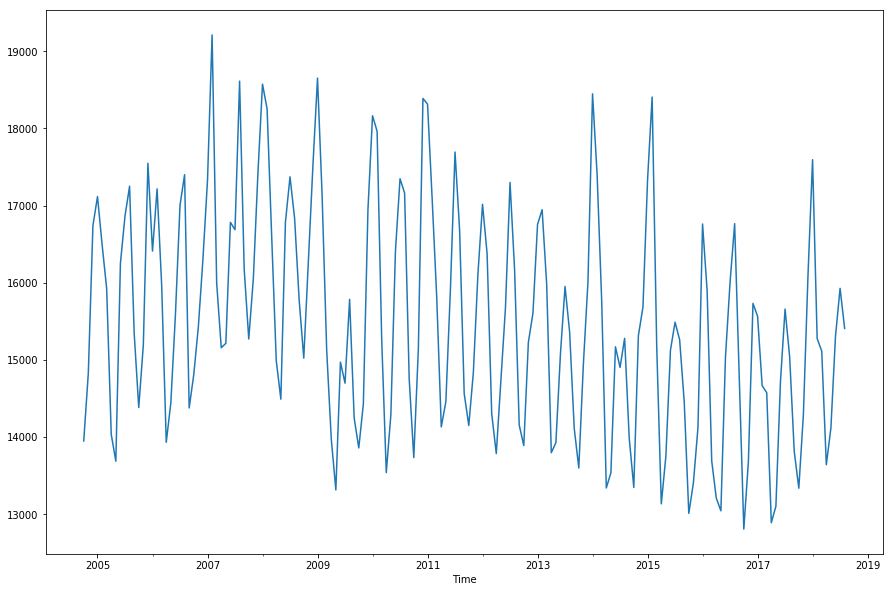

In [11]:
y.plot()
plt.show()

### Some distinguishable patterns appear when we plot the data. The time series has an obvious seasonality pattern, as well as an increasing, decreasing, and increasing trend.

### We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

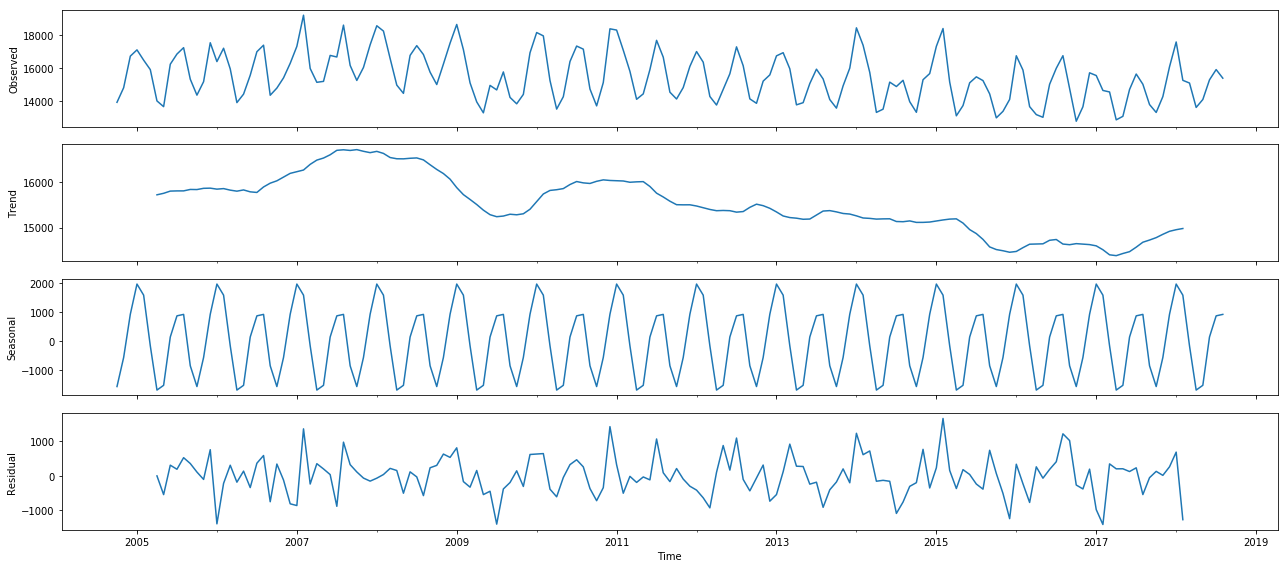

In [12]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

### The plot above clearly shows that the energy consumption is unstable, along with its obvious seasonality.

## Train/Test Split¶
### Cut off the data after 2017-01-01 to use as our validation set.

In [13]:
split_date = '2017-01-01'
y_train = y.loc[y.index < split_date].copy()
y_test = y.loc[y.index >= split_date].copy()

# Time series forecasting with ARIMA

## Parameter Selection for the ARIMA Time Series Model
### We will select the optimum ARIMA model with the lowest AIC (Akaike Information Criterion) value. A grid search technique will be used to find the optimal parameters in (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters, and in (P,D,Q,s) order of the seasonal component of the model for the AR parameters, differences, MA parameters, and periodicity.

In [14]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

In [15]:
opt_pdq=(0,0,0)
opt_PDQ=(0,0,0,0)
opt_AIC=10000

In [16]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            #print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            if results.aic<opt_AIC:
                opt_pdq=param
                opt_PDQ=param_seasonal
                opt_AIC=results.aic
        except:
            continue

print('Optimal SARIMA Model {}x{} - AIC:{}'.format(opt_pdq, opt_PDQ, opt_AIC))

C:\Users\SH\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1052: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not params_seasonal_variance == []:
C:\Users\SH\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


Optimal SARIMA Model (1, 1, 1)x(1, 1, 1, 12) - AIC:1931.0630422427375


### Parameter order of (p,d,q)=(1,1,1) and seasonal order of (P,D,Q,s)=(1,1,1,12) has been selected.

## Fitting an ARIMA Time Series Model
### Using grid search, we have identified the set of parameters that produces the best fitting model to our time series data. We can proceed to analyze this particular model in more depth.

### We'll start by plugging the optimal parameter values into a new SARIMAX model:

In [17]:
mod = sm.tsa.statespace.SARIMAX(y_train,
                                order=opt_pdq,
                                seasonal_order=opt_PDQ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4412      0.083      5.329      0.000       0.279       0.603
ma.L1         -0.9997      0.148     -6.770      0.000      -1.289      -0.710
ar.S.L12       0.0940      0.054      1.735      0.083      -0.012       0.200
ma.S.L12      -0.7974      0.101     -7.869      0.000      -0.996      -0.599
sigma2      4.598e+05   3.24e-07   1.42e+12      0.000     4.6e+05     4.6e+05


###  The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

## Model Diagnostics

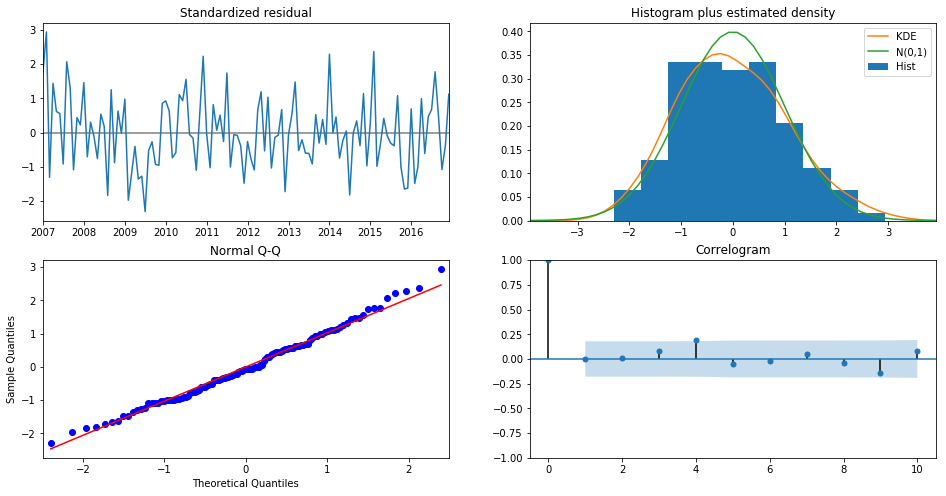

In [18]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

### Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

### In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:

### In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.
### The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.
### The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.
### Those observations lead us to conclude that our model produces a satisfactory fit that could help us understand our time series data and forecast future values.

### Although we have a satisfactory fit, some parameters of our seasonal ARIMA model could be changed to improve our model fit. For example, our grid search only considered a restricted set of parameter combinations, so we may find better models if we widened the grid search.

## Validating Forecasts
### We have obtained a model for our time series that can now be used to produce forecasts. We start by comparing predicted values to real values of the time series, which will help us understand the accuracy of our forecasts.
### The dynamic=False argument ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.

### We can plot the real and forecasted values of the energy consumption time series to assess how well we did. The prediction date is set to start from 2017-01-01, which is the start date in the test set, to the end date of the dateset.

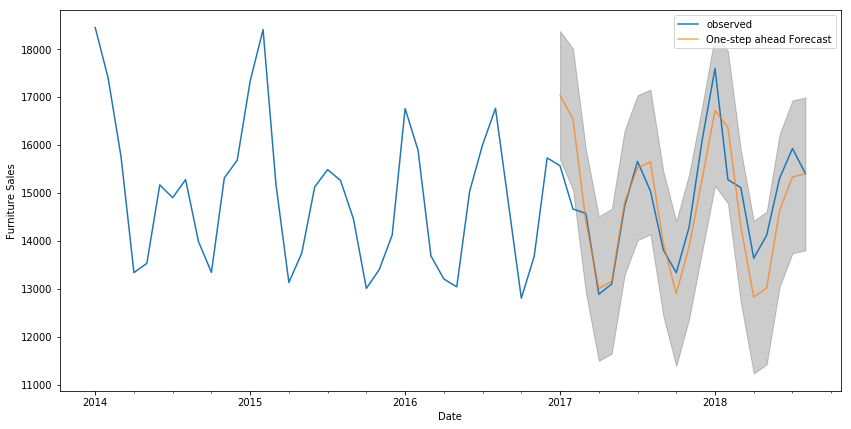

In [19]:
pred = results.get_prediction(start=pd.to_datetime(split_date),
                              end=y.index.max(),
                              dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

### Overall, our forecasts align with the true values very well, showing an overall increase trend.

### It is also useful to quantify the accuracy of our forecasts. We will use the RMSE (Root Mean Squared Error) and MAPE (Mean Absolute Percentage Error) for metric evaluation.

In [20]:
def RMSE(forecast,truth):
    diff=forecast-truth
    RMSE = np.sqrt((diff ** 2).mean())
    print('The Root Mean Squared Error of our forecasts (RMSE) is {}'.format(round(RMSE, 2)))

In [21]:
def MAPE(forecast,truth):
    diff=forecast-truth
    MAPE=abs(diff/truth).mean()*100
    print('The Mean Absolute Percentage Error (MAPE) of our forecasts is {}%'.format(round(MAPE, 2)))

In [22]:
y_forecast = pred.predicted_mean
y_truth=y_test

## RMSE

In [23]:
RMSE(y_forecast,y_truth)

The Root Mean Squared Error of our forecasts (RMSE) is 787.82


## MAPE

In [24]:
MAPE(y_forecast,y_truth)

The Mean Absolute Percentage Error (MAPE) of our forecasts is 4.07%


## Producing and Visualizing Forecasts

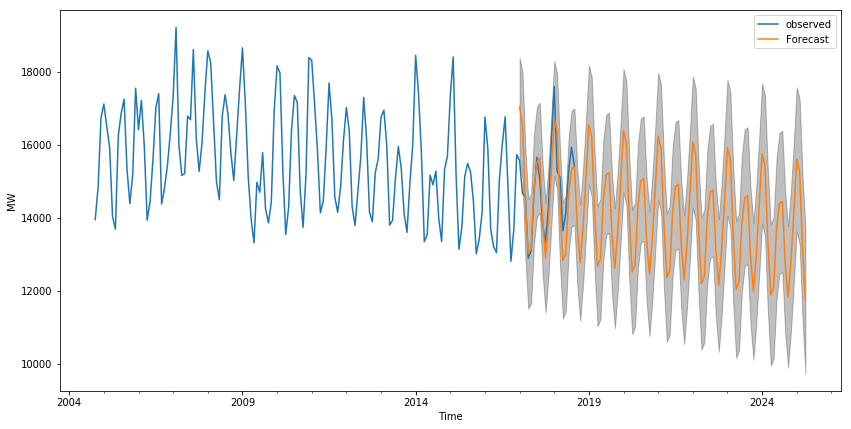

In [25]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Time')
ax.set_ylabel('MW')
plt.legend()
plt.show()

### Both the forecasts and associated confidence interval that we have generated can now be used to further understand the time series and foresee what to expect. Our forecasts show that the time series is expected to continue increasing at a steady pace.

### As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

## Time Series Modeling with Prophet
### Released by Facebook in 2017, forecasting tool Prophet is designed for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. Therefore, we are using Prophet to get a model up and running.

In [26]:
y_train_fb=y_train.reset_index()

In [27]:
model = Prophet(interval_width=0.95)
model.fit(y_train_fb.rename(columns={'Time':'ds', 'MW':'y'}))

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [28]:
y_test_fb=y_test.reset_index()

In [29]:
forecast_time=pd.DataFrame(y_test_fb['Time'])
forecast_time.columns=['ds']

In [30]:
y_forecast_fb = model.predict(forecast_time)
y_forecast_fb.head(1)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,14642.548009,15273.102815,17806.173196,14641.833782,14643.313218,1889.989515,1889.989515,1889.989515,1889.989515,1889.989515,1889.989515,0.0,0.0,0.0,16532.537524


## Forecast Evaluation

## RMSE

In [31]:
RMSE(y_forecast_fb['yhat'],y_test_fb['MW'])

The Root Mean Squared Error of our forecasts (RMSE) is 751.72


## MAPE

In [32]:
MAPE(y_forecast_fb['yhat'],y_test_fb['MW'])

The Mean Absolute Percentage Error (MAPE) of our forecasts is 4.0%


In [33]:
y_forecast_fb.head(1)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,14642.548009,15273.102815,17806.173196,14641.833782,14643.313218,1889.989515,1889.989515,1889.989515,1889.989515,1889.989515,1889.989515,0.0,0.0,0.0,16532.537524


In [34]:
df1=pd.DataFrame(y_forecast_fb['yhat'])
df2=df1.set_index(y_forecast_fb['ds'])

In [35]:
df3=pd.DataFrame(y_forecast_fb[['yhat_lower','yhat_upper']])
df4=df3.set_index(y_forecast_fb['ds'])

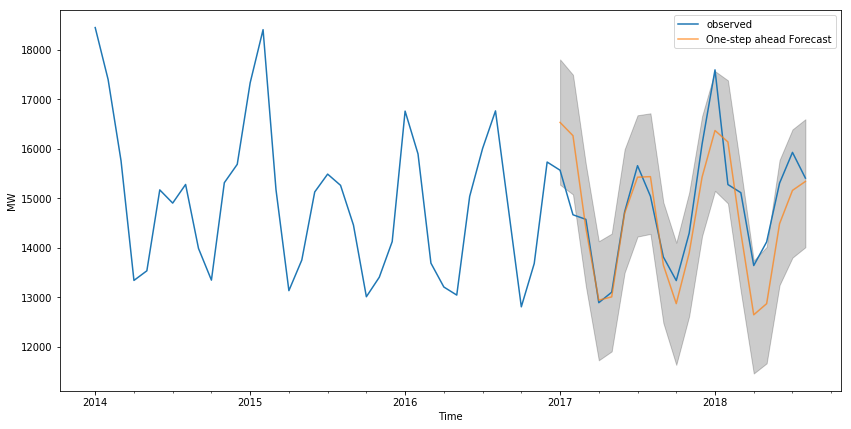

In [36]:
ax = y['2014':].plot(label='observed')
df2.iloc[:,0].plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(df4.index,
                df4.iloc[:, 0],
                df4.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Time')
ax.set_ylabel('MW')
plt.legend()
plt.show()

### Overall, our forecasts align with the true values very well, showing an overall increase trend.

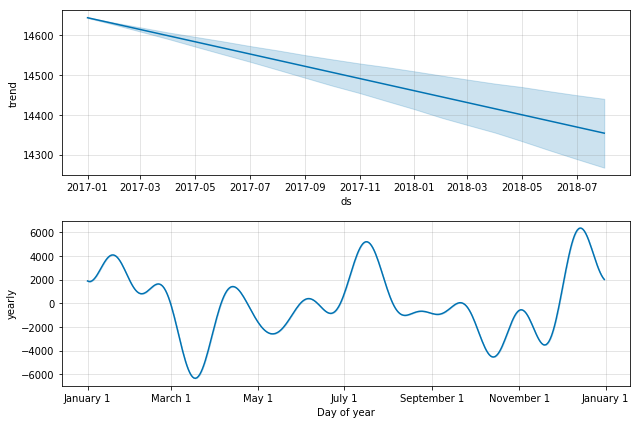

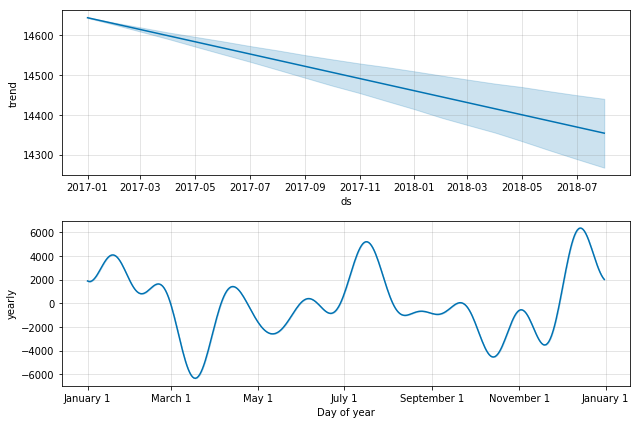

In [37]:
model.plot_components(y_forecast_fb)

## LSTM

https://www.kaggle.com/diegovicente/particle-levels-prediction-using-lstm

https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/

https://machinelearningmastery.com/use-different-batch-sizes-training-predicting-python-keras/

In [40]:
# univariate one step problem
from numpy import array
from keras.preprocessing.sequence import TimeseriesGenerator
# define dataset
series = array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
# define generator
n_input = 2
generator = TimeseriesGenerator(series, series, length=n_input, batch_size=1)
# number of samples
print('Samples: %d' % len(generator))
# print each sample
for i in range(len(generator)):
    x, y = generator[i]
    print('%s => %s' % (x, y))

Samples: 8
[[1. 2.]] => [3.]
[[2. 3.]] => [4.]
[[3. 4.]] => [5.]
[[4. 5.]] => [6.]
[[5. 6.]] => [7.]
[[6. 7.]] => [8.]
[[7. 8.]] => [9.]
[[8. 9.]] => [10.]


## MLP (Multi-Layer Perceptron)

In [41]:
# univariate one step problem with mlp
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import TimeseriesGenerator
# define dataset
series = array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
# define generator
n_input = 2
generator = TimeseriesGenerator(series, series, length=n_input, batch_size=8)
# define model
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=n_input))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit_generator(generator, steps_per_epoch=1, epochs=200, verbose=0)
# make a one step prediction out of sample
x_input = array([9, 10]).reshape((1, n_input))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[11.474104]]


## LSTM

In [42]:
# univariate one step problem with lstm
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
# define dataset
series = array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
# reshape to [10, 1]
n_features = 1
series = series.reshape((len(series), n_features))
series

array([[ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10]])

In [43]:
# univariate one step problem with lstm
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
# define dataset
series = array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
# reshape to [10, 1]
n_features = 1
series = series.reshape((len(series), n_features))
# define generator
n_input = 2
generator = TimeseriesGenerator(series, series, length=n_input, batch_size=8)
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit_generator(generator, steps_per_epoch=1, epochs=500, verbose=0)
# make a one step prediction out of sample
x_input = array([9, 10]).reshape((1, n_input, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[10.967839]]


In [44]:
x_input

array([[[ 9],
        [10]]])